<a href="https://colab.research.google.com/github/amit6604/Scikit-Learn/blob/master/SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVM (Support Vector Machines)

In this notebook, you will use SVM (Support Vector Machines) to build and train a model using human cell records, and classify cells to whether the samples are benign or malignant.

SVM works by mapping data to a high-dimensional feature space so that data points can be categorized, even when the data are not otherwise linearly separable. A separator between the categories is found, then the data are transformed in such a way that the separator could be drawn as a hyperplane. Following this, characteristics of new data can be used to predict the group to which a new record should belong.

In [0]:
import pandas as pd
import numpy as np
from scipy import optimize as opt
from matplotlib import pyplot as plt
import pylab as pl
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline

###  Load the Cancer data 
The example is based on a dataset that is publicly available from the UCI Machine Learning Repository (Asuncion and Newman, 2007)[http://mlearn.ics.uci.edu/MLRepository.html]. The dataset consists of several hundred human cell sample records, each of which contains the values of a set of cell characteristics. The fields in each record are:

|Field name|Description|
|--- |--- |
|ID|Clump thickness|
|Clump|Clump thickness|
|UnifSize|Uniformity of cell size|
|UnifShape|Uniformity of cell shape|
|MargAdh|Marginal adhesion|
|SingEpiSize|Single epithelial cell size|
|BareNuc|Bare nuclei|
|BlandChrom|Bland chromatin|
|NormNucl|Normal nucleoli|
|Mit|Mitoses|
|Class|Benign or malignant|

For the purposes of this example, we're using a dataset that has a relatively small number of predictors in each record. To download the data, we will use `!wget` to download it from IBM Object Storage.  

In [5]:
!wget -O cell_samples.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv

--2019-06-09 12:05:33--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/cell_samples.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.193
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20675 (20K) [text/csv]
Saving to: ‘cell_samples.csv’

cell_samples.csv    100%[===================>]  20.19K  --.-KB/s    in 0.02s   

2019-06-09 12:05:33 (1.23 MB/s) - ‘cell_samples.csv’ saved [20675/20675]



In [7]:
# Load Data from csv file

df = pd.read_csv("cell_samples.csv")
df.head()

,ID,Clump,UnifSize,UnifShape,MargAdh,SingEpiSize,BareNuc,BlandChrom,NormNucl,Mit,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The ID field contains the patient identifiers. The characteristics of the cell samples from each patient are contained in fields Clump to Mit. The values are graded from 1 to 10, with 1 being the closest to benign.

The Class field contains the diagnosis, as confirmed by separate medical procedures, as to whether the samples are benign (value = 2) or malignant (value = 4).

Lets look at the distribution of the classes based on Clump thickness and Uniformity of cell size:

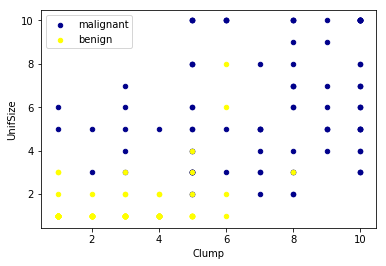

In [11]:
ax = df[df['Class'] == 4][0:100].plot(kind='scatter', x='Clump', y='UnifSize', color='DarkBlue', label='malignant');
df[df['Class'] == 2][0:100].plot(kind='scatter', x='Clump', y='UnifSize', color='Yellow', label='benign', ax=ax);
plt.show()

## Data pre-processing and selection

Lets first look at columns data types:

In [12]:
df.dtypes

ID              int64
Clump           int64
UnifSize        int64
UnifShape       int64
MargAdh         int64
SingEpiSize     int64
BareNuc        object
BlandChrom      int64
NormNucl        int64
Mit             int64
Class           int64
dtype: object

It looks like the __BareNuc__ column includes some values that are not numerical. We can drop those rows:

In [13]:
df = df[pd.to_numeric(df['BareNuc'], errors='coerce').notnull()]
df['BareNuc'] = df['BareNuc'].astype('int')
df.dtypes

ID             int64
Clump          int64
UnifSize       int64
UnifShape      int64
MargAdh        int64
SingEpiSize    int64
BareNuc        int64
BlandChrom     int64
NormNucl       int64
Mit            int64
Class          int64
dtype: object

In [14]:
df.columns

Index(['ID', 'Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize',
       'BareNuc', 'BlandChrom', 'NormNucl', 'Mit', 'Class'],
      dtype='object')

In [16]:
# Features Declaration

X = np.asarray(df[['Clump', 'UnifSize', 'UnifShape', 'MargAdh', 'SingEpiSize','BareNuc', 'BlandChrom', 'NormNucl', 'Mit']])
X[0:5]

array([[ 5,  1,  1,  1,  2,  1,  3,  1,  1],
       [ 5,  4,  4,  5,  7, 10,  3,  2,  1],
       [ 3,  1,  1,  1,  2,  2,  3,  1,  1],
       [ 6,  8,  8,  1,  3,  4,  3,  7,  1],
       [ 4,  1,  1,  3,  2,  1,  3,  1,  1]])

We want the model to predict the value of Class (that is, benign (=2) or malignant (=4)). As this field can have one of only two possible values, we need to change its measurement level to reflect this.

In [17]:
# Target Declaration

y = np.asarray(df['Class']).astype(int)
y[0:5]

array([2, 2, 2, 2, 2])

## Train/Test dataset

Okay, we split our dataset into train and test set:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=.3, random_state=4)
print("Train Set: ", X_train.shape, y_train.shape)
print("Test Set: ", X_test.shape, y_test.shape)

Train Set:  (478, 9) (478,)
Test Set:  (205, 9) (205,)


The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, **mapping data into a higher dimensional space is called kernelling.** The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

    1.Linear
    2.Polynomial
    3.Radial basis function (RBF)
    4.Sigmoid
Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.

In [29]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', gamma='scale')
clf

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [30]:
# Fit our model using training dataset

clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [31]:
# Predict test values

y_test_ = clf.predict(X_test)
y_test_[0:5]

array([2, 4, 2, 4, 2])

## Evaluation

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

           2       0.98      0.95      0.97       132
           4       0.91      0.97      0.94        73

    accuracy                           0.96       205
   macro avg       0.95      0.96      0.95       205
weighted avg       0.96      0.96      0.96       205

Confusion matrix, without normalization
[[125   7]
 [  2  71]]


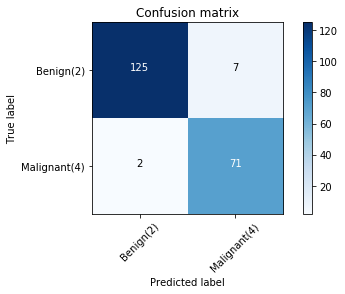

In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_test_))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

You can also easily use the __f1_score__ fron sklearn library:

In [36]:
from sklearn.metrics import f1_score
f1_score(y_test, y_test_, average='weighted')

0.9564006538324096

In [48]:
# Lets try jaccard index for accuracy:

from sklearn.metrics import jaccard_similarity_score, jaccard_score
jaccard_similarity_score(y_test, y_test_)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


0.9560975609756097

In [44]:
# Linear kernel

clf2 = svm.SVC(kernel='linear')
clf2.fit(X_train, y_train) 
y_pred = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, y_pred, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, y_pred))

Avg F1-score: 0.9372
Jaccard score: 0.9366


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [50]:
# Polynomial kernel

clf2 = svm.SVC(kernel='poly', gamma='scale')
clf2.fit(X_train, y_train) 
y_pred = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, y_pred, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, y_pred))

Avg F1-score: 0.9418
Jaccard score: 0.9415


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)


In [53]:
# Sigmoid kernel

clf2 = svm.SVC(kernel='sigmoid', gamma='scale')
clf2.fit(X_train, y_train) 
y_pred = clf2.predict(X_test)
print("Avg F1-score: %.4f" % f1_score(y_test, y_pred, average='weighted'))
print("Jaccard score: %.4f" % jaccard_similarity_score(y_test, y_pred))

Avg F1-score: 0.4004
Jaccard score: 0.4439


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:635: DeprecationWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  'and multiclass classification tasks.', DeprecationWarning)
